In [25]:
import os
from collections import Counter

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import probscale
import itertools
import csv

from pathlib import Path

class Result:
    def __init__(self, path):
        self.path = Path(f"results/{path}/flamestream")
    
    def lat_data(self):
        with open(self.path.joinpath("latency/lat.data"), 'r') as file:
            return list(map(int, file.read().split(", ")))
    
    def notification_await_times(self):
        with open(self.path.joinpath("notification_await_times.csv"), 'r') as file:
            return list(map(lambda row: int(row[0]) / 1E6, csv.reader(file)))
        
    def duration(self):
        with open(self.path.joinpath("duration.txt"), 'r') as file:
            return int(file.read())
        
    def durations(self):
        with open(self.path.joinpath("durations.txt"), 'r') as file:
            return list(map(int, file.read().split(", ")))
    
    def throughput_hz(self, skip=0):
        durations = self.durations()
        return (len(durations) - skip) / (durations[-1] - durations[skip]) * 1E9

    def plot_latencies_evolution(self, **kwargs):
        plot_quantiles_evolution(self.lat_data(), **kwargs)
        
def plot_quantiles_evolution(data, window_size=100, q=0.95, stabilize=True):
    quantiles = []
    prev_quantile = None
    is_stable = not stabilize
    for window in each_slice(data, window_size):
        quantile = np.quantile(window, q)
        if is_stable:
            quantiles.append(quantile)
        elif prev_quantile and prev_quantile < quantile:
            is_stable = True
            quantiles.append(prev_quantile)
            quantiles.append(quantile)
        else:
            prev_quantile = quantile
        prev_window = window
    if not is_stable:
        raise "has not stabilized"
    plt.plot(quantiles)
        
def results_path(parallelism=3, rate=5, watermarks=False):
    return Path(f"results/sigmod/parallelism={parallelism}/distributed_acker={False}/rate={rate}/watermarks={watermarks}/iterations=10/flamestream")

def plot_probabilities(results_by_legends, legend_title=None, plot_title=None):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.legend(results_by_legends.keys(), title=legend_title)
    for result in results_by_legends.values():
        plt.plot(*probscale.plot_pos(result.lat_data()))
    plt.xlabel('Percentile')
    plt.ylabel('Latency, ns')
    plt.title(plot_title)
    plt.show()
    
def plot_percentile(percentile, results_by_rates):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(
        results_by_rates.keys(),
        [np.percentile(result.lat_data(), percentile) for result in results_by_rates.values()],
        marker='o'
    )
    plt.xlabel('Rate')
    plt.ylabel(f"Latencies {percentile} percentile, ns")
    
def plot_percentile_by_throughput(percentile, results):
    plt.plot(*plottable_percentile_by_throughput(percentile, results))
    
def plottable_percentile_by_throughput(percentile, results):
    return (
        [result.throughput() for result in results],
        [np.percentile(result.lat_data(), percentile) for result in results]
    )

def plot_throughput_by_number_of_iterations(results):
    plt.plot(
        [result.iterations for result in results],
        [result.throughput() for result in results],
    )
    
def show_max_throughput(result_factory, bad_rate, max_rate):
    pass

def plot_throughput_by_parallelism(results):
    plt.plot(
        [result.parallelism for result in results],
        [result.throughput_hz() for result in results],
    )
    
def plot_latencies_barh(results_by_labels, ax):
    w = .70
    ind_fs = [1, 2.0, 3.0]

    def do_plot(q, c):
        ax.barh(range(len(results_by_labels)), [np.percentile(result.lat_data(), q) for result in results_by_labels.values()], color=c, height=w, left=0)

    do_plot(99, '.8')
    do_plot(90, '.6')
    do_plot(75, '.4')
    do_plot(50, '.2')

    plt.gca().invert_yaxis()

    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(60)

    ax.set_yticklabels([])
#     plt.xlim((0, np.percentile(latencies[8], 99) + 100))

    ax.set_xlabel('Latency(ms)', fontsize=60)

    for i, label in enumerate(results_by_labels):
        ax.text(np.percentile(results_by_labels[label].lat_data(), 99) + 10, i, label, fontsize = 60)

    patch_99 = mpatches.Patch(color='.8', label='99 %-ile')
    patch_90 = mpatches.Patch(color='.6', label='95 %-ile')
    patch_75 = mpatches.Patch(color='.4', label='75 %-ile')
    patch_50 = mpatches.Patch(color='.2', label='50 %-ile')
    ax.legend(handles=[patch_99, patch_90, patch_75, patch_50][::-1], fontsize = 60, frameon=False, bbox_to_anchor=(1, 1), ncol=1)

    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
def each_slice(generator, n):
    group = []
    for element in generator:
        group.append(element)
        if len(group) == n:
            yield group
            group = []

    if group:
        yield group

In [2]:
plt.plot(*zip(*(
    (LOCAL_ACKER_FLUSH_COUNT, np.quantile(Result(
        path=f"sigmod.07.30.idle-cpu-level=5/iterations=100/rate=2/LOCAL_ACKER_FLUSH_COUNT={LOCAL_ACKER_FLUSH_COUNT}/LOCAL_ACKER_FLUSH_DELAY_IN_MILLIS=5"
    ).lat_data(), 0.5) / 1E6)
    for LOCAL_ACKER_FLUSH_COUNT in [500, 1000, 2000]
)), marker='o')

NameError: name 'Result' is not defined

## Idle-cpu-level=5

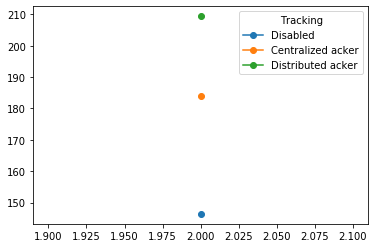

In [4]:
plt.legend([
    plt.plot(*zip(*(
        (rate, np.quantile(Result(
            path=f"sigmod.07.30.idle-cpu-level=5/iterations=100/rate={rate}/tracking_frequency=0/tracking=disabled"
        ).lat_data(), 0.5) / 1E6)
        for rate in [2]
    )), marker='o') and "Disabled",
    plt.plot(*zip(*(
        (rate, np.quantile(Result(
            path=f"sigmod.07.30.idle-cpu-level=5/iterations=100/rate={rate}/tracking_frequency=1/tracking=acking/distributed=False"
        ).lat_data(), 0.5) / 1E6)
        for rate in [2]
    )), marker='o') and "Centralized acker",
    plt.plot(*zip(*(
        (rate, np.quantile(Result(
            path=f"sigmod.07.30.idle-cpu-level=5/iterations=100/rate={rate}/tracking_frequency=1/tracking=acking/distributed=True"
        ).lat_data(), 0.5) / 1E6)
        for rate in [2]
    )), marker='o') and "Distributed acker",
], title="Tracking")

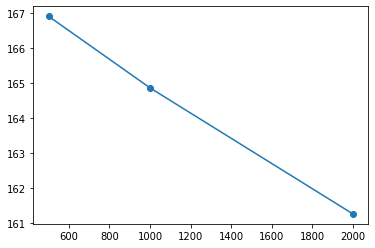

In [5]:
plt.plot(*zip(*(
    (LOCAL_ACKER_FLUSH_COUNT, np.quantile(Result(
        path=f"sigmod.07.30.idle-cpu-level=5/iterations=100/rate=2/distributed=True/LOCAL_ACKER_FLUSH_COUNT={LOCAL_ACKER_FLUSH_COUNT}/LOCAL_ACKER_FLUSH_DELAY_IN_MILLIS=2"
    ).lat_data(), 0.5) / 1E6)
    for LOCAL_ACKER_FLUSH_COUNT in [500, 1000, 2000]
)), marker='o')

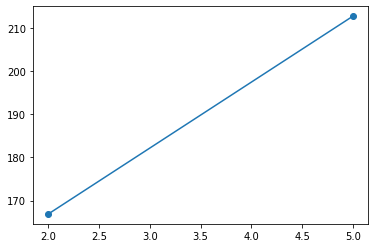

In [6]:
plt.plot(*zip(*(
    (LOCAL_ACKER_FLUSH_DELAY_IN_MILLIS, np.quantile(Result(
        path=f"sigmod.07.30.idle-cpu-level=5/iterations=100/rate=2/distributed=True/LOCAL_ACKER_FLUSH_COUNT=500/LOCAL_ACKER_FLUSH_DELAY_IN_MILLIS={LOCAL_ACKER_FLUSH_DELAY_IN_MILLIS}"
    ).lat_data(), 0.5) / 1E6)
    for LOCAL_ACKER_FLUSH_DELAY_IN_MILLIS in [2, 5]
)), marker='o')

In [ ]:
plt.legend([
    plt.plot(*zip(*(
        (rate, np.quantile(Result(
            path=f"sigmod.09.17/iterations=50/rate={rate}/tracking_frequency=1/tracking=acking/distributed=False"
        ).notification_await_times(), 0.5))
        for rate in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    )), marker='o') and "Centralized acker",
    plt.plot(*zip(*(
        (rate, np.quantile(Result(
            path=f"sigmod.09.17/iterations=50/rate={rate}/tracking_frequency=1/tracking=acking/distributed=True"
        ).notification_await_times(), 0.5))
        for rate in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  )), marker='o') and "Distributed acker",
], title="Tracking")

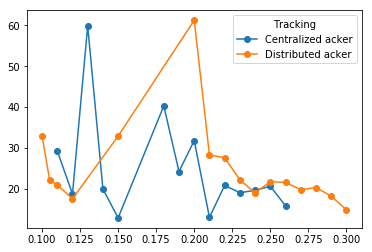

In [41]:
from glob import glob
import re

plt.legend([
    plt.plot(*zip(*(
        (float(rate), np.quantile(Result(
            path=f"sigmod.09.21/iterations=10/rate={rate}/tracking_frequency=1/tracking=acking/distributed=False"
        ).notification_await_times(), 0.5))
        for rate in sorted(set([
          re.search("rate=(\d+(?:\.\d*)?)", path)[1]
          for path in glob(f'results/sigmod.09.21/iterations=10/rate=*/tracking_frequency=1/tracking=acking/distributed=False')
        ]) - {'0.1'}, key=float)
    )), marker='o') and "Centralized acker",
    plt.plot(*zip(*(
        (float(rate), np.quantile(Result(
            path=f"sigmod.09.21/iterations=10/rate={rate}/tracking_frequency=1/tracking=acking/distributed=True"
        ).notification_await_times(), 0.5))
        for rate in sorted(set([
          re.search("rate=(\d+(?:\.\d*)?)", path)[1]
          for path in glob(f'results/sigmod.09.21/iterations=10/rate=*/tracking_frequency=1/tracking=acking/distributed=True')
        ]) - {'0.09', '0.101', '0.19', '0.145', '0.14', '0.13'}, key=float)
  )), marker='o') and "Distributed acker",
], title="Tracking")